<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr%5Cmodely_RP%5CR_tabilao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pynverse

  Created wheel for pynverse: filename=pynverse-0.1.4.4-cp36-none-any.whl size=6350 sha256=c045ae896ace2f86ea70fd39ec98998b01065e2bd2db9d78f2a64cb20a7e79c6
  Stored in directory: /root/.cache/pip/wheels/80/ab/86/ec93f37613f012ba3e65c2bbd67e5c54cbc00d237574100c24
Successfully built pynverse


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad

from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')
tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)

tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)

tilyvoatana.index = pd.to_datetime(tilyvoatana.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)

tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [40]:
# Voa vaovao (observed incidence)
Ivao = tilyvoamdg['Voatomb']

dIvao = pd.DataFrame(data =Ivao)


# Hoan'ny taha sorisoritry ny fifindrana (infectioness profile distribution)

daty_data_manom = datetime.date(2020,6,1)
daty_data_mifar = datetime.date(2020,8,1)

datyt = daty_data_mifar - datetime.timedelta(days = 1)

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Planning tool: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

#discr_si1 = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0) 
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1, (t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1, k):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).
# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [ ]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

# for i in range(8):
# t = t_mif - i - 1
# k = 9

APEt91 = []
Prt91 = []

APE91 = 0

for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2) - 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

# for i in range(9):
# t = t_mif - 1 - 9 + 1 - i
# k = t_mif - t - 2*i
APEt92 = []
Prt92 = []

APE92 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2)-1):
  t = daty_data_mifar - datetime.timedelta(days = 1) - datetime.timedelta(days = ((daty_data_mifar - daty_data_manom).days + 1)/2) + datetime.timedelta(days = 1) - datetime.timedelta(days = i)
  k = (daty_data_mifar - t - datetime.timedelta(days = 2*i)).days
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k) ,t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0
# so that pnb(t_man + 1, 2) = 0 and 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(inf, datetime.date(2020, 7, 5)), (inf, datetime.date(2020, 7, 4)), (inf, datetime.date(2020, 7, 3)), (inf, datetime.date(2020, 7, 2)), (inf, datetime.date(2020, 7, 1)), (inf, datetime.date(2020, 6, 30)), (inf, datetime.date(2020, 6, 29)), (inf, datetime.date(2020, 6, 28)), (inf, datetime.date(2020, 6, 27)), (inf, datetime.date(2020, 6, 26)), (inf, datetime.date(2020, 6, 25)), (inf, datetime.date(2020, 6, 24)), (inf, datetime.date(2020, 6, 23)), (inf, datetime.date(2020, 6, 22)), (inf, datetime.date(2020, 6, 21)), (inf, datetime.date(2020, 6, 20)), (inf, datetime.date(2020, 6, 19)), (inf, datetime.date(2020, 6, 18)), (inf, datetime.date(2020, 6, 17)), (inf, datetime.date(2020, 6, 16)), (inf, datetime.date(2020, 6, 15)), (inf, datetime.date(2020, 6, 14)), (inf, datetime.date(2020, 6, 13)), (inf, datetime.date(2020, 6, 12)), (inf, datetime.date(2020, 6, 11)), (inf, datetime.date(2020, 6, 10)), (inf, datetime.date(2020, 6, 9)), (inf, datetime.date(2020, 6,

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log


APEk1 = [1901.0970879193835, 5246.1580023556735, 9391.531159659084, 13995.432976173577, inf, inf, inf]
APEk2 = [2.697839127258707, 17.34521918646036, 31.109646393598382, 45.004266434333545, 76.34598039790463, 111.95416379774284, 169.42670413085253]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [1903.7949270466422, 5263.503221542134, 9422.640806052683, 14040.43724260791, inf, inf, inf]
APE = [1903.7949270466422, 5263.503221542134, 9422.640806052683, 14040.43724260791, inf, inf, inf, inf]
2


# Choice of the prior hyperparameters

In [5]:
kk = 2

  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


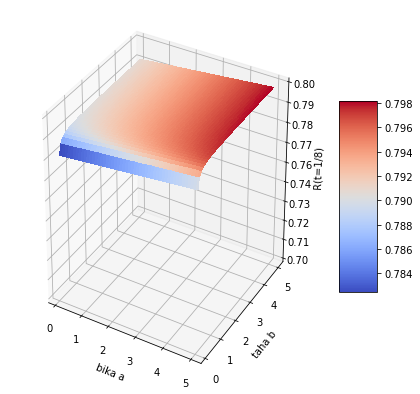

In [7]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.7, 0.8)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=1/8)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt18_mdg.eps')

plt.show()

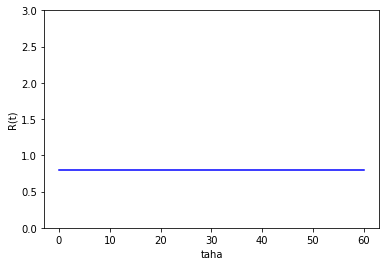

taha* = 1
R(t= 2020-08-01 ) = 0.7908827749759968 = bika*


In [8]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,60,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,3)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


# Direct computation of R(t)

In [9]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)


print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,7,20)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-08-01 : 1.2290132107016138
Salan'isa R hoan'ny 2020-07-20 : 0.49529277514701403
Kartily @ 75% R hoan'ny 2020-07-20 : 0.51413052384636
Kartily @ 25% R hoan'ny 2020-07-20 : 0.47586412185482785
Salan'isa R hoan'ny 2020-08-01 : 0.7908827712927655
Kartily @ 75% R hoan'ny 2020-08-01 : 0.81386529797337
Kartily @ 25% R hoan'ny 2020-08-01 : 0.7673537565182242


In [14]:
rt_mdg_lst = []

daty_oh2 = daty_data_mifar
for i in range(32):
  t = daty_oh2 - datetime.timedelta(days = i)
  rt_amboar = Rt_salan(t)
  rt_mdg_lst.append((t,Rt_salan(t)))

rt_mdg_lst

[(datetime.date(2020, 8, 1), array(0.79088277)),
 (datetime.date(2020, 7, 31), array(0.82851654)),
 (datetime.date(2020, 7, 30), array(0.97739697)),
 (datetime.date(2020, 7, 29), array(0.96528936)),
 (datetime.date(2020, 7, 28), array(1.26110022)),
 (datetime.date(2020, 7, 27), array(1.28033692)),
 (datetime.date(2020, 7, 26), array(0.85047758)),
 (datetime.date(2020, 7, 25), array(0.74572485)),
 (datetime.date(2020, 7, 24), array(0.90830044)),
 (datetime.date(2020, 7, 23), array(1.14486246)),
 (datetime.date(2020, 7, 22), array(1.64587504)),
 (datetime.date(2020, 7, 21), array(1.00411325)),
 (datetime.date(2020, 7, 20), array(0.49529278)),
 (datetime.date(2020, 7, 19), array(0.99054494)),
 (datetime.date(2020, 7, 18), array(1.37056665)),
 (datetime.date(2020, 7, 17), array(1.63715321)),
 (datetime.date(2020, 7, 16), array(1.46878651)),
 (datetime.date(2020, 7, 15), array(1.07102194)),
 (datetime.date(2020, 7, 14), array(1.03113542)),
 (datetime.date(2020, 7, 13), array(1.19337223)),
 

In [15]:
rt_mdg_lst[0]

(datetime.date(2020, 8, 1), array(0.79088277))

In [12]:
# MRC results 

r_mdg197 = 1.41
r_mdg177 = 1.45
r_mdg147 = 1.32
r_mdg137 = 1.3
r_mdg107 = 1.31
r_mdg067 = 1.49
r_mdg037 = 1.47
r_mdg027 = 1.42
r_mdg017 = 1.36
r_mdg256 = 1.89
r_mdg226 = 1.45
r_mdg206 = 1.26
r_mdg186 = 1.41
r_mdg166 = 1.33
r_mdg156 = 1.07
r_mdg146 = 0.9
r_mdg136 = 1.13
r_mdg086 = 1.92
r_mdg056 = 2.01
r_mdg036 = 2.02
r_mdg016 = 2.1
r_mdg315 = 2.11
r_mdg305 = 2.15

In [16]:
elan_mdg197 = r_mdg197 - rt_mdg_lst[13][1]
elan_mdg177 = r_mdg177 - rt_mdg_lst[15][1]
elan_mdg147 = r_mdg147 - rt_mdg_lst[18][1]
elan_mdg137 = r_mdg137 - rt_mdg_lst[19][1]
elan_mdg107 = r_mdg107 - rt_mdg_lst[22][1]
elan_mdg067 = r_mdg067 - rt_mdg_lst[26][1]

elan_mdg037 = r_mdg037 - rt_mdg_lst[29][1]
elan_mdg027 = r_mdg027 - rt_mdg_lst[30][1]

print('197',elan_mdg197,rt_mdg_lst[13])
print('177',elan_mdg177,rt_mdg_lst[15])
print('147',elan_mdg147,rt_mdg_lst[18])
print('137',elan_mdg137,rt_mdg_lst[19])
print('107',elan_mdg107,rt_mdg_lst[22])
print('067',elan_mdg067,rt_mdg_lst[26])
print('037',elan_mdg037,rt_mdg_lst[29])
print('027',elan_mdg027,rt_mdg_lst[30])


197 0.419455061247609 (datetime.date(2020, 7, 19), array(0.99054494))
177 -0.1871532063543382 (datetime.date(2020, 7, 17), array(1.63715321))
147 0.2888645811130286 (datetime.date(2020, 7, 14), array(1.03113542))
137 0.10662777467567519 (datetime.date(2020, 7, 13), array(1.19337223))
107 -0.49561986597109975 (datetime.date(2020, 7, 10), array(1.80561987))
067 -1.2955358652333515 (datetime.date(2020, 7, 6), array(2.78553587))
037 -0.5726881910960302 (datetime.date(2020, 7, 3), array(2.04268819))
027 0.028270813347863744 (datetime.date(2020, 7, 2), array(1.39172919))


In [ ]:
037 -0.5726098483113142 (datetime.date(2020, 7, 3), array(2.04260985))
027 0.02835208638426856 (datetime.date(2020, 7, 2), array(1.39164791))
256 0.8021534559475563 (datetime.date(2020, 6, 25), array(1.08784654))
226 -0.5014916536325702 (datetime.date(2020, 6, 22), array(1.95149165))
206 -0.361306138560324 (datetime.date(2020, 6, 20), array(1.62130614))
186 -0.02162642793571723 (datetime.date(2020, 6, 18), array(1.43162643))
166 0.6492157941416283 (datetime.date(2020, 6, 16), array(0.68078421))
156 0.526489774932504 (datetime.date(2020, 6, 15), array(0.54351023))
146 0.32353315210354017 (datetime.date(2020, 6, 14), array(0.57646685))
136 0.4749572987988042 (datetime.date(2020, 6, 13), array(0.6550427))
086 1.0543351102904648 (datetime.date(2020, 6, 8), array(0.86566489))
056 1.139592276201465 (datetime.date(2020, 6, 5), array(0.87040772))
036 0.931962123621884 (datetime.date(2020, 6, 3), array(1.08803788))
016 1.1491939416892416 (datetime.date(2020, 6, 1), array(0.95080606))
315 0.7537546213260404 (datetime.date(2020, 5, 31), array(1.35624538))
305 0.5758312750280978 (datetime.date(2020, 5, 30), array(1.57416872))

In [17]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -27)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +27)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(1000)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


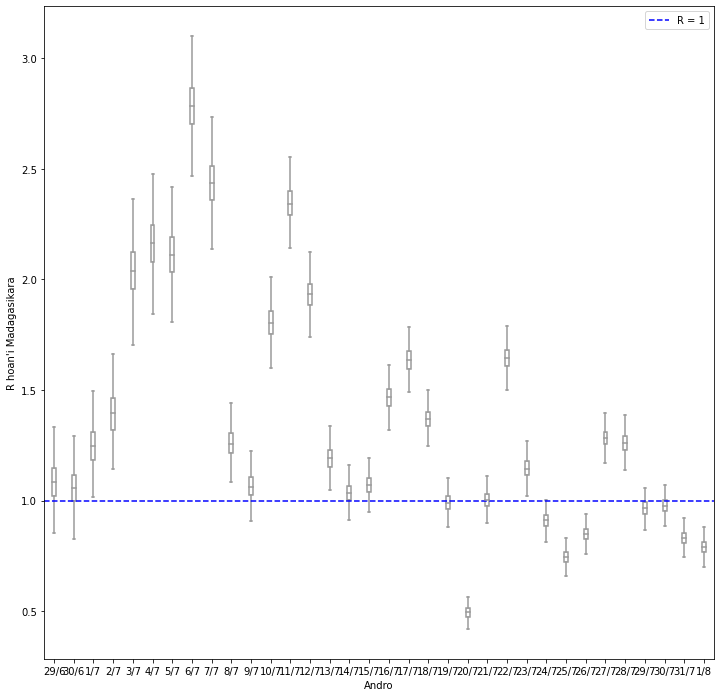

In [18]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(12, 12))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Madagasikara")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt18_mdg.eps')
plt.savefig(path_to_save+'Rt18_mdg.png')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


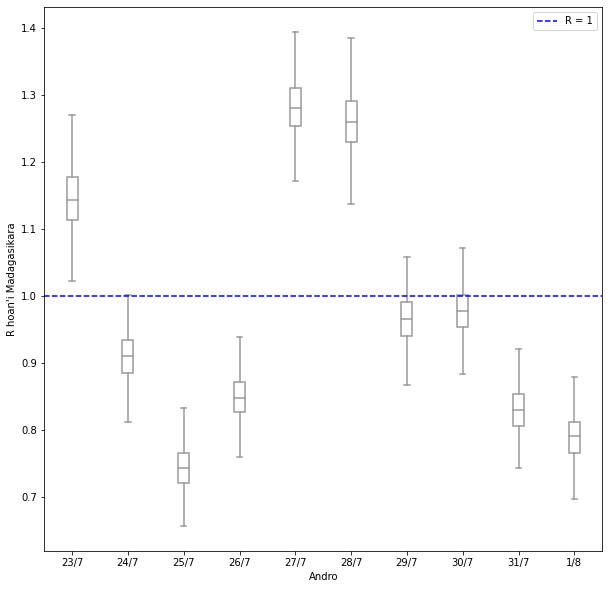

In [19]:
# Plotting the last 10 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Madagasikara")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'Rt1810_mdg.eps')
plt.savefig(path_to_save+'Rt1810_mdg.png')

plt.show()

# Jeritodika ny herinandro

In [30]:
daty_ambaj = datetime.date(2020,7,25)
daty_amboj = datetime.date(2020,7,28)

daty_data_mifarj = datetime.date(2020,7,25)

In [31]:
daty_oh1 = daty_ambaj

print("Tombana ambany: R ",daty_oh1,':',  Rt_salan(daty_oh1))
print("75%-kartily R :",':', perc75(daty_oh1))
print("25%-kartily R :", perc25(daty_oh1))

daty_oh2 = daty_amboj

print("Tombana ambony: R", daty_oh2,':', Rt_salan(daty_oh2))
print("75%-kartily R :",':', perc75(daty_oh2))
print("25%-kartily R :", perc25(daty_oh2))


Tombana ambany: R  2020-07-25 : 0.7457248530403032
75%-kartily R : : 0.7682592058594064
25%-kartily R : 0.722632734949979
Tombana ambony: R 2020-07-28 : 1.2611002174538497
75%-kartily R : : 1.290692952830308
25%-kartily R : 1.2309419783966196


Ambany

In [32]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_amba_hitsiny = 0
Rt_vinaj = Rt_salan(daty_ambaj) + Rt_amba_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [33]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_baj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_baj.append(data_amboar)


Ambony

In [38]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

# Rt_ambo_hitsiny = (Rt_salan(daty_ambaj)- Rt_salan(daty_amboj))/2

Rt_ambo_hitsiny = 0
Rt_vinaj = Rt_salan(daty_amboj) + Rt_ambo_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [39]:
# Sampling 

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_boj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_boj.append(data_amboar)


Sary

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


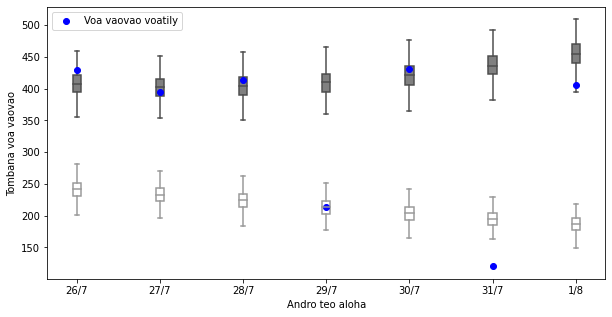

In [41]:
# Plotting the evaluation of the last 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_j_lst, data_baj, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_j_lst, data_boj, color='grey', width=0.1, showfliers=False, ax=ax)
ax.plot(daty_j_lst, dIvao.loc[pd.to_datetime(daty_m1j):pd.to_datetime(daty_m1j + datetime.timedelta(days = 6))], marker ="o",ls = 'None', color='blue',label="Voa vaovao voatily")
ax.set(xlabel = 'Andro teo aloha', ylabel="Tombana voa vaovao")

plt.legend(loc= 'best')

plt.savefig(path_to_save+'Iv267j_mdg.eps')
plt.savefig(path_to_save+'Iv267j_mdg.png')

plt.show()

## Andro 7 manaraka

In [42]:
# Choice of R(t) for the forecasting

# Dates for which R(t) is minimum and maximum during the last 10 days

daty_amba = datetime.date(2020,7,31)
daty_ambo = datetime.date(2020,7,28)

In [43]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_amba)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,8):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_amba)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


## Vinavina hafa

In [ ]:
# Choice of R(t) for the forecasting

# Dates for which R(t) is minimum and maximum during the last 10 days

daty_amba = datetime.date(2020,6,15)
daty_ambo = datetime.date(2020,6,11)


### Hafa ambany

In [ ]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_amba)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,200):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_amba)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [ ]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month))

daty_hoav_lst = []

data_amba_hoav = []

Ivv_dat = []

for i in range(1,200):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_amba_hoav.append(data_amboar)

In [ ]:
print('Vinavina hafa ambany')

daty_oh = datetime.date(2020,9,13) 

Ireh_mifar = 6089

print("Notombanana avy amin'ny R(", daty_amba, ')', Rt_salan(daty_amba)) 
print("Vinavina R hoan'ny", daty_oh, ':', Rt_salan(daty_oh))
print("Vinavina kartily @ 75% R hoan'ny",daty_oh, ':', perc75(daty_oh))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', perc25(daty_oh))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_oh, ':', dIvao['Voatomb'].loc[format_date(daty_oh)])

print("Vinavina kartily @ 75% R hoan'ny", daty_oh, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_oh)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_oh)]))

print("Isan'ny voa rehetra hatr@", daty_oh, ':', Ireh_mifar + Ireh(daty_oh,(daty_oh - daty_data_mifar).days))

Vinavina hafa ambany
Notombanana avy amin'ny R( 2020-06-15 ) 0.543510225067496
Vinavina R hoan'ny 2020-09-13 : 0.2829119815637407
Vinavina kartily @ 75% R hoan'ny 2020-09-13 : 0.39006751921805327
Vinavina kartily @ 25% R hoan'ny 2020-09-13 : 0.10187573291040768
Vinavina isan'ny voa vaovao hoan'ny 2020-09-13 : 0.0
Vinavina kartily @ 75% R hoan'ny 2020-09-13 : [0.]
Vinavina kartily @ 25% R hoan'ny 2020-09-13 : [0.]
Isan'ny voa rehetra hatr@ 2020-09-13 : 8320.0


### Hafa ambony

In [ ]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_ambo)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,200):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_ambo)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [ ]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month))

daty_hoav_lst = []

data_ambo_hoav = []

Ivv_dat = []

for i in range(1,200):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_ambo_hoav.append(data_amboar)

In [ ]:
print('Vinavina ambony')

daty_oh = datetime.date(2020,9,16)

print("Notombanana avy amin'ny R(", daty_ambo, ')', Rt_salan(daty_ambo)) 
print("Vinavina R hoan'ny", daty_oh, ':', Rt_salan(daty_oh))
print("Vinavina kartily @ 75% R hoan'ny",daty_oh, ':', perc75(daty_oh))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', perc25(daty_oh))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_oh, ':', dIvao['Voatomb'].loc[format_date(daty_oh)])

print("Vinavina kartily @ 75% R hoan'ny", daty_oh, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_oh)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_oh)]))

print("Isan'ny voa rehetra hatr@", daty_oh, ':', Ireh_mifar + Ireh(daty_oh,(daty_oh - daty_data_mifar).days))

Vinavina ambony
Notombanana avy amin'ny R( 2020-06-11 ) 0.8446466465307488
Vinavina R hoan'ny 2020-09-16 : 0.8373441188029643
Vinavina kartily @ 75% R hoan'ny 2020-09-16 : 0.8897603570083598
Vinavina kartily @ 25% R hoan'ny 2020-09-16 : 0.7821597886958924
Vinavina isan'ny voa vaovao hoan'ny 2020-09-16 : 54.0
Vinavina kartily @ 75% R hoan'ny 2020-09-16 : [66.]
Vinavina kartily @ 25% R hoan'ny 2020-09-16 : [49.]
Isan'ny voa rehetra hatr@ 2020-09-16 : 14280.0


### Sary

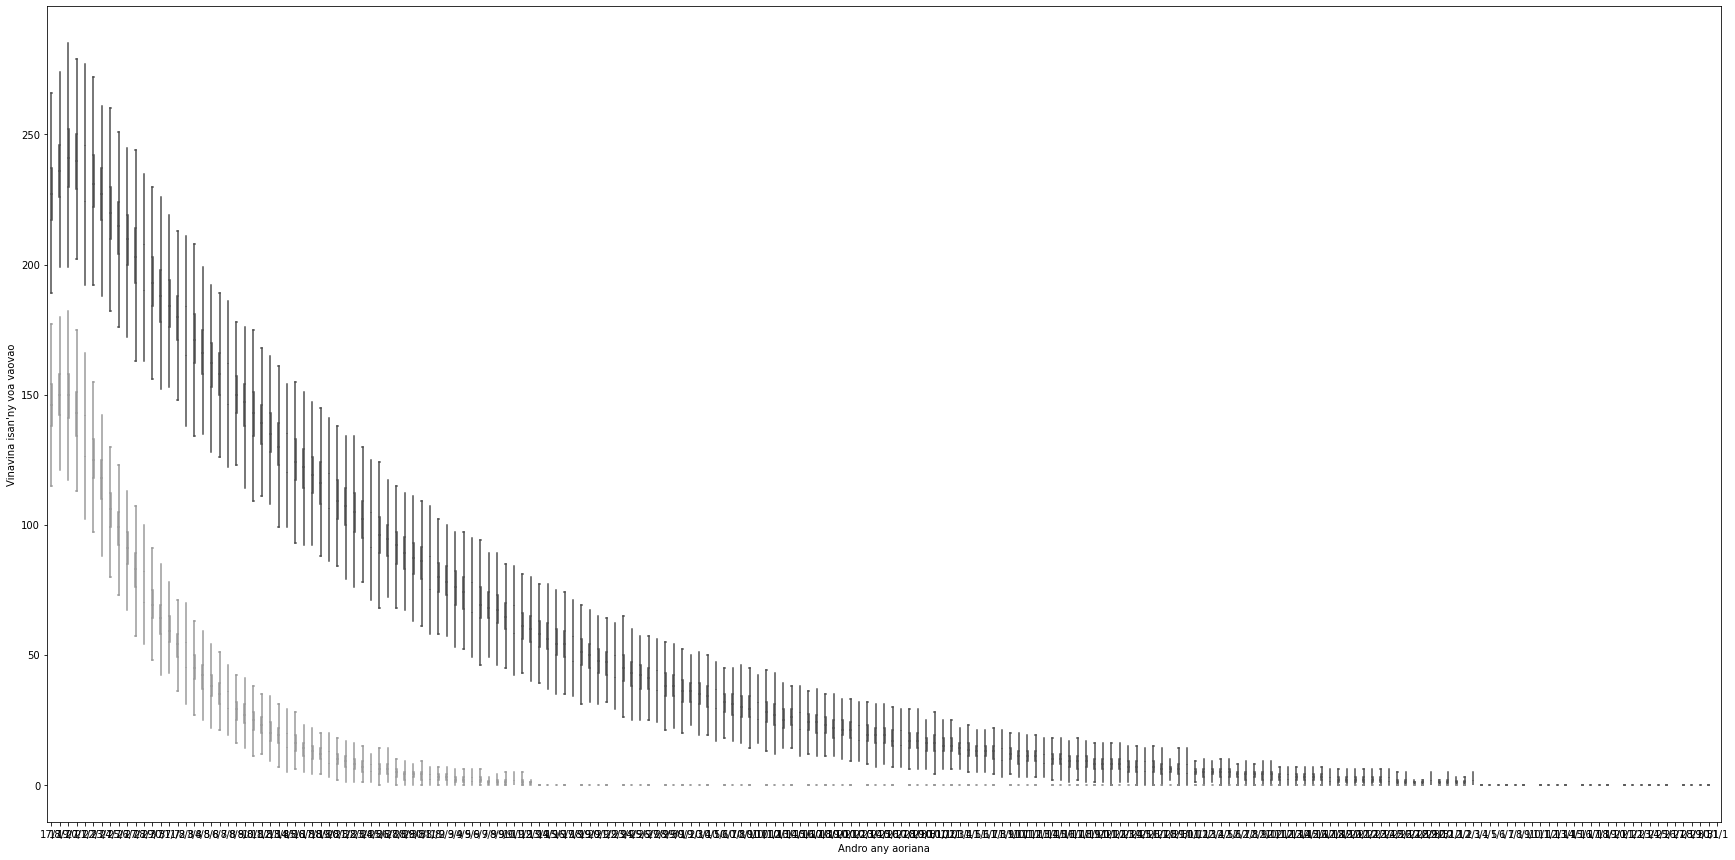

In [ ]:
# Plotting boundaries for the next 7 days

fig, ax = plt.subplots(figsize=(30,15))
box = sns.boxplot(daty_hoav_lst, data_amba_hoav, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_hoav_lst, data_ambo_hoav, color='grey', width=0.1, showfliers=False, ax=ax)

ax.set_xlabel('Andro any aoriana')
ax.set_ylabel("Vinavina isan'ny voa vaovao")

plt.savefig(path_to_save+'Iv167ahoav_mdg.eps')
plt.savefig(path_to_save+'Iv167ahoav_mdg.png')

plt.show()

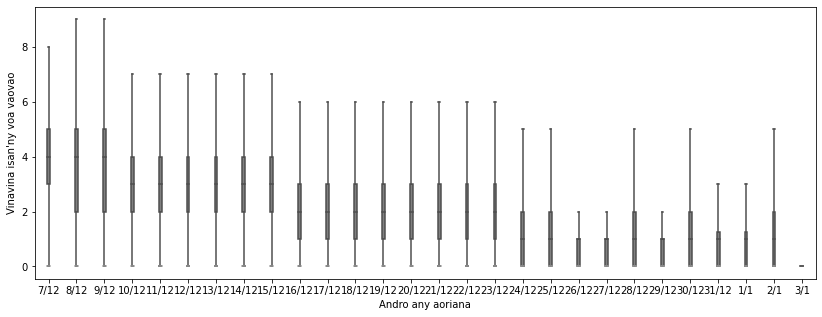

In [ ]:
# Plotting boundaries for the next 7 days

fig, ax = plt.subplots(figsize=(14,5))
box = sns.boxplot(daty_hoav_lst[143:171], data_amba_hoav[143:171], color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_hoav_lst[143:171], data_ambo_hoav[143:171], color='grey', width=0.1, showfliers=False, ax=ax)

ax.set_xlabel('Andro any aoriana')
ax.set_ylabel("Vinavina isan'ny voa vaovao")

plt.savefig(path_to_save+'Iv167a31hoav_mdg.eps')
plt.savefig(path_to_save+'Iv167a31hoav_mdg.png')

plt.show()